# Readability Assessment throughConvolutional Neural Network

Readability assessment is a well known problem in natural language processing field. Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. In this notebook we are trying to assess the readability of a given text regardless of the text subject using recurrent neural network.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [26]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.engine.input_layer import Input

import numpy as np

# glove = load_glove_embeddings()
corpus = load_corpus()
articles, tags = corpus_to_words(corpus)

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [27]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles[i][:words])], 
        ["Intermediate",detokenize(articles[i+2][:words])], 
        ["Elementary",detokenize(articles[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 10px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [28]:
maxlen = 1000 # Cuts off reviews after 100 words
training_samples = 450
validation_samples = 117
max_words = 45
articles, tags = corpus_to_pos(corpus)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles)
print(tokenizer.word_index)
print(len(tokenizer.word_index))


{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}
44


In [29]:
sequences = tokenizer.texts_to_sequences(articles)
# print(sequences)
print(np.shape(sequences))


(567,)


In [30]:

data = pad_sequences(sequences, maxlen=maxlen)
print(data)
print(np.shape(data))

[[ 0  0  0 ...  2 17  8]
 [ 0  0  0 ...  2 17  8]
 [ 0  0  0 ...  2 17  8]
 ...
 [ 0  0  0 ...  4  1  8]
 [ 0  0  0 ...  4  1  8]
 [ 0  0  0 ...  4  1  8]]
(567, 1000)


In [31]:
print(np.shape(tags))
labels = to_categorical(tags)
print(np.shape(labels))

(567,)
(567, 3)


In [32]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
print(np.shape(data), np.shape(labels), np.shape(data[0]))

x_train= data[:training_samples]
y_train= labels[:training_samples]
print(np.shape(x_train), np.shape(y_train))

x_val =data[training_samples:]
y_val =labels[training_samples:]
print(np.shape(x_val), np.shape(y_val))
from tensorflow.python import keras


(567, 1000) (567, 3) (1000,)
(450, 1000) (450, 3)
(117, 1000) (117, 3)


In [33]:
data = data.reshape(data.shape[0], data.shape[1], 1)
model = Sequential()
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))

model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))
# model.summary()

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='acc',patience=10, verbose=1, mode='auto')

model.compile(optimizer=RMSprop(),
loss='categorical_crossentropy',
metrics=['acc'])
history = model.fit(data, labels,
epochs=50,                 
validation_split=0.2)
model.save_weights('pre_trained_glove_model.h5')
model.summary()

Train on 453 samples, validate on 114 samples
Epoch 1/200
453/453 [==============================] - 1s 1ms/step - loss: 1.8615 - acc: 0.5519 - val_loss: 1.5425 - val_acc: 0.3860
Epoch 2/200
453/453 [==============================] - 0s 213us/step - loss: 0.8734 - acc: 0.6291 - val_loss: 1.4242 - val_acc: 0.4123
Epoch 3/200
453/453 [==============================] - 0s 213us/step - loss: 0.7921 - acc: 0.6645 - val_loss: 1.1142 - val_acc: 0.5175
Epoch 4/200
453/453 [==============================] - 0s 200us/step - loss: 0.7920 - acc: 0.6645 - val_loss: 1.3802 - val_acc: 0.3772
Epoch 5/200
453/453 [==============================] - 0s 200us/step - loss: 0.7327 - acc: 0.6733 - val_loss: 1.3921 - val_acc: 0.4561
Epoch 6/200
453/453 [==============================] - 0s 203us/step - loss: 0.6690 - acc: 0.7329 - val_loss: 2.5708 - val_acc: 0.3509
Epoch 7/200
453/453 [==============================] - 0s 198us/step - loss: 0.8659 - acc: 0.6954 - val_loss: 1.3236 - val_acc: 0.4298
Epoch 8/200

Epoch 61/200
453/453 [==============================] - 0s 196us/step - loss: 0.3421 - acc: 0.8985 - val_loss: 2.0926 - val_acc: 0.4035
Epoch 62/200
453/453 [==============================] - 0s 192us/step - loss: 0.2900 - acc: 0.8940 - val_loss: 2.2919 - val_acc: 0.4386
Epoch 63/200
453/453 [==============================] - 0s 193us/step - loss: 0.2610 - acc: 0.9227 - val_loss: 1.5951 - val_acc: 0.4035
Epoch 64/200
453/453 [==============================] - 0s 188us/step - loss: 0.1953 - acc: 0.9669 - val_loss: 1.2509 - val_acc: 0.4474
Epoch 65/200
453/453 [==============================] - 0s 191us/step - loss: 0.3388 - acc: 0.8830 - val_loss: 1.2603 - val_acc: 0.4649
Epoch 66/200
453/453 [==============================] - 0s 190us/step - loss: 0.2555 - acc: 0.9051 - val_loss: 1.4230 - val_acc: 0.4386
Epoch 67/200
453/453 [==============================] - 0s 194us/step - loss: 0.2392 - acc: 0.9294 - val_loss: 1.4610 - val_acc: 0.4035
Epoch 68/200
453/453 [==========================

453/453 [==============================] - 0s 192us/step - loss: 0.0453 - acc: 0.9890 - val_loss: 1.5289 - val_acc: 0.4474
Epoch 122/200
453/453 [==============================] - 0s 198us/step - loss: 0.0244 - acc: 1.0000 - val_loss: 2.0057 - val_acc: 0.4211
Epoch 123/200
453/453 [==============================] - 0s 187us/step - loss: 0.2420 - acc: 0.9272 - val_loss: 1.5284 - val_acc: 0.4649
Epoch 124/200
453/453 [==============================] - 0s 192us/step - loss: 0.0242 - acc: 1.0000 - val_loss: 1.5677 - val_acc: 0.4298
Epoch 125/200
453/453 [==============================] - 0s 193us/step - loss: 0.1787 - acc: 0.9514 - val_loss: 1.5882 - val_acc: 0.4211
Epoch 126/200
453/453 [==============================] - 0s 188us/step - loss: 0.1589 - acc: 0.9536 - val_loss: 1.5332 - val_acc: 0.4737
Epoch 127/200
453/453 [==============================] - 0s 190us/step - loss: 0.0213 - acc: 1.0000 - val_loss: 1.5961 - val_acc: 0.4123
Epoch 128/200
453/453 [==============================] 

Epoch 181/200
453/453 [==============================] - 0s 196us/step - loss: 0.0836 - acc: 0.9713 - val_loss: 4.5016 - val_acc: 0.3684
Epoch 182/200
453/453 [==============================] - 0s 199us/step - loss: 0.1059 - acc: 0.9735 - val_loss: 1.8062 - val_acc: 0.4649
Epoch 183/200
453/453 [==============================] - 0s 198us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 1.8353 - val_acc: 0.4474
Epoch 184/200
453/453 [==============================] - 0s 186us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 1.9832 - val_acc: 0.3947
Epoch 185/200
453/453 [==============================] - 0s 219us/step - loss: 0.2832 - acc: 0.9183 - val_loss: 1.8077 - val_acc: 0.4561
Epoch 186/200
453/453 [==============================] - 0s 219us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 1.8296 - val_acc: 0.4298
Epoch 187/200
453/453 [==============================] - 0s 209us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 1.8384 - val_acc: 0.4649
Epoch 188/200
453/453 [==================

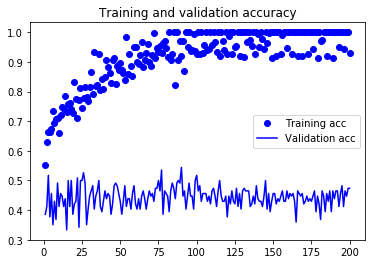

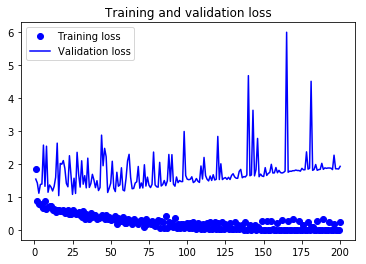

In [43]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


